### Załadowanie bibliotek i zboru

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy.stats import mannwhitneyu

In [2]:
df = pd.read_csv("RDKit_2D_computed_activity_bin_fin_fp_ready_P28223.csv")
df.head()

,canonical_smiles,activity_bin,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,O=S(=O)(c1cccc(F)c1)N1CCC(CCc2ccc(F)cc2F)CC1,0,13.685105,-3.694886,13.685105,0.037654,0.778336,383.435,363.275,383.116685,...,0,1,0,0,0,0,0,0,0,0
1,O=C(c1ccc(F)cc1)C1CCN(CCn2c(=O)[nH]c3ccccc3c2=...,0,13.044694,-0.407339,13.044694,0.048003,0.673576,395.434,373.258,395.164520,...,0,0,0,0,0,0,0,0,0,0
2,COc1cc2c3c(c1OCc1ccccc1)-c1cc4c(cc1CC3N(C)CC2)...,0,6.480325,0.272957,6.480325,0.272957,0.614776,415.489,390.289,415.178358,...,0,0,0,0,0,0,0,0,0,0
3,Cn1ncc(Br)c1-c1cc(NC(=O)Nc2ccc(Cl)cc2)ccc1OCCN...,0,12.483640,-0.342550,12.483640,0.342550,0.425703,518.843,493.643,517.088015,...,0,0,0,0,0,0,0,0,0,1
4,CNCCc1cccc2[nH]cc(S(=O)(=O)c3ccccc3)c12,0,12.899290,-3.521439,12.899290,0.318814,0.761024,314.410,296.266,314.108899,...,0,0,1,0,0,0,0,0,0,0


### Rozkład zmiennej docelowej

In [3]:
print("\nRozkład activity_bin:")
print(df["activity_bin"].value_counts())


Rozkład activity_bin:
activity_bin
0    315
1    241
Name: count, dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21920\1068509893.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x="activity_bin", palette=colors)


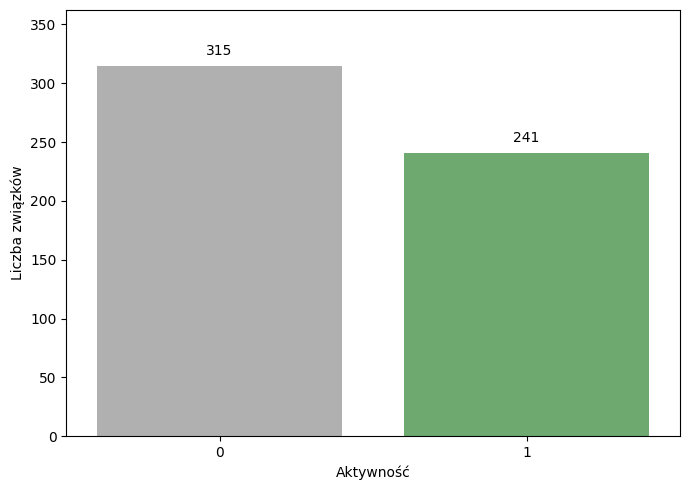

In [4]:
plt.figure(figsize=(7, 5))

colors = ["#b0b0b0cb", "#64b467"]
ax = sns.countplot(data=df, x="activity_bin", palette=colors)

max_count = df["activity_bin"].value_counts().max()
ax.set_ylim(0, max_count * 1.15)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2., height + max_count * 0.02),
        ha="center",
        va="bottom",
        fontsize=10,
    )

ax.set_xlabel("Aktywność")
ax.set_ylabel("Liczba związków")

plt.tight_layout()

## Eksploracja danych

In [5]:
X = df.drop(columns=['canonical_smiles', 'activity_bin'])
y = df['activity_bin']

print(f"Liczba zmiennych objaśniających: {X.shape[1]}")

Liczba zmiennych objaśniających: 208


### Identyfikacja cech o zerowej wariancji

In [6]:
X = df.drop(columns=['canonical_smiles', 'activity_bin'])
y = df['activity_bin']

zero_var_cols = X.columns[X.nunique(dropna=False) <= 1]
print(f"Zidentyfikowano {len(zero_var_cols)} cech o wariancji = 0")

X_var = X.drop(columns=zero_var_cols)
print(f"Liczba cech po filtracji wariancji: {X_var.shape[1]}")

Zidentyfikowano 36 cech o wariancji = 0
Liczba cech po filtracji wariancji: 172


### Analiza korelacji

In [7]:
corr_threshold = 0.90
corr_matrix = X_var.corr().abs()

In [8]:
# górny trójkąt macierzy korelacji (bez przekątnej), żeby każda para była tylko raz
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

In [9]:
# identyfikacja kolumn do usunięcia
to_drop_corr = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] >= corr_threshold)
]
print(f"Zidentyfikowano {len(to_drop_corr)} cech do usunięcia (korelacja >= {corr_threshold})")

Zidentyfikowano 49 cech do usunięcia (korelacja >= 0.9)


In [10]:
X_eda = X_var.drop(columns=to_drop_corr)
print(f"Liczba cech po filtracji wysokiej korelacji: {X_eda.shape[1]}")

Liczba cech po filtracji wysokiej korelacji: 123


### Identyfikacja wielowymiarowych wartości odstających

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact

In [12]:
assert isinstance(X_eda, pd.DataFrame), "X_eda powinno być DataFrame"
assert X_eda.shape[0] == df.shape[0], "X_eda i df muszą mieć tę samą liczbę wierszy"
assert "activity_bin" in df.columns, "Brakuje kolumny activity_bin w df"

print("X_eda shape:", X_eda.shape)  # (556, 123)

X_eda shape: (556, 123)


In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eda)

In [14]:
TREES_LIST = [500, 1000, 1500]
SEEDS = [0, 21, 42]
CONT = 0.05

n = X_scaled.shape[0]
flags = np.zeros((len(TREES_LIST) * len(SEEDS), n), dtype=np.int8)

In [15]:
TREES_LIST = [500, 1000, 1500, 2000]
SEEDS = [0, 21, 42, 63]
CONT = 0.05

n = X_scaled.shape[0]
flags = np.zeros((len(TREES_LIST) * len(SEEDS), n), dtype=np.int8)

In [16]:
run = 0
for t in TREES_LIST:
    for s in SEEDS:
        iso = IsolationForest(
            n_estimators=t,
            contamination=CONT,
            random_state=s,
            n_jobs=-1
        )
        labels = iso.fit_predict(X_scaled)  # -1 outlier, 1 normal
        out_mask = (labels == -1).astype(np.int8)
        flags[run, :] = out_mask
        run += 1
        print(f"trees={t}, seed={s} -> outliery: {out_mask.sum()} ({100*out_mask.mean():.2f}%)")

trees=500, seed=0 -> outliery: 28 (5.04%)
trees=500, seed=21 -> outliery: 28 (5.04%)
trees=500, seed=42 -> outliery: 28 (5.04%)
trees=500, seed=63 -> outliery: 28 (5.04%)
trees=1000, seed=0 -> outliery: 28 (5.04%)
trees=1000, seed=21 -> outliery: 28 (5.04%)
trees=1000, seed=42 -> outliery: 28 (5.04%)
trees=1000, seed=63 -> outliery: 28 (5.04%)
trees=1500, seed=0 -> outliery: 28 (5.04%)
trees=1500, seed=21 -> outliery: 28 (5.04%)
trees=1500, seed=42 -> outliery: 28 (5.04%)
trees=1500, seed=63 -> outliery: 28 (5.04%)
trees=2000, seed=0 -> outliery: 28 (5.04%)
trees=2000, seed=21 -> outliery: 28 (5.04%)
trees=2000, seed=42 -> outliery: 28 (5.04%)
trees=2000, seed=63 -> outliery: 28 (5.04%)


In [17]:
outlier_freq = flags.mean(axis=0)

df_out = df.copy()
df_out["outlier_freq"] = outlier_freq

In [18]:
# progi
CONS_STRICT = 1.00
CONS_SOFT = 0.80

mask_strict = df_out["outlier_freq"] >= CONS_STRICT
mask_soft = df_out["outlier_freq"] >= CONS_SOFT

print("Twardy konsensus (100%):", mask_strict.sum())
print("Miękki konsensus (>=80%):", mask_soft.sum())

df_out["is_outlier"] = mask_soft

Twardy konsensus (100%): 25
Miękki konsensus (>=80%): 28


#### Tabela kontyngencji z częstością outlierów w podziale na klasy

In [19]:
ct_cnt = pd.crosstab(df_out["is_outlier"], df_out["activity_bin"])
ct_pct = pd.crosstab(df_out["is_outlier"], df_out["activity_bin"], normalize="index")

print("\nLiczby:\n", ct_cnt)
print("\nProcenty (wiersze=1):\n", ct_pct)


Liczby:
 activity_bin    0    1
is_outlier            
False         292  236
True           23    5

Procenty (wiersze=1):
 activity_bin         0         1
is_outlier                      
False         0.553030  0.446970
True          0.821429  0.178571


#### Dokładny test Fishera

In [20]:
a = ct_cnt.loc[False, 0] if (False in ct_cnt.index and 0 in ct_cnt.columns) else 0
b = ct_cnt.loc[False, 1] if (False in ct_cnt.index and 1 in ct_cnt.columns) else 0
c = ct_cnt.loc[True,  0] if (True  in ct_cnt.index and 0 in ct_cnt.columns) else 0
d = ct_cnt.loc[True,  1] if (True  in ct_cnt.index and 1 in ct_cnt.columns) else 0

table_2x2 = np.array([[a, b],
                      [c, d]], dtype=int)

oddsratio, p_value = fisher_exact(table_2x2, alternative="two-sided")

print("\nFisher exact (2-sided):")
print("tablica 2x2:\n", table_2x2)
print(f"OR = {oddsratio:.3f}, p = {p_value:.6f}")


Fisher exact (2-sided):
tablica 2x2:
 [[292 236]
 [ 23   5]]
OR = 0.269, p = 0.005487


#### PCA do wizualizacji 2D

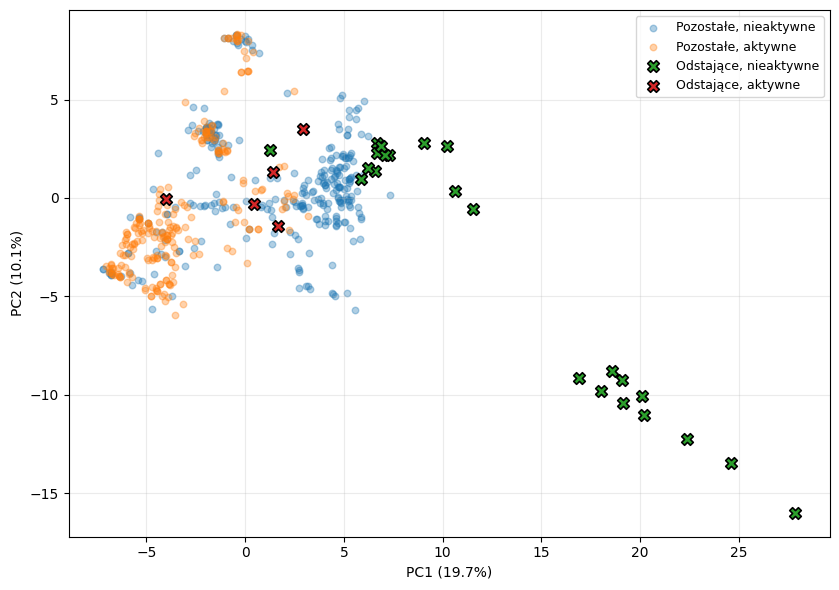

In [21]:
pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X_scaled)
evr = pca.explained_variance_ratio_

is_out = df_out["is_outlier"].to_numpy()
y = df_out["activity_bin"].to_numpy()

plt.figure(figsize=(8.5, 6.0))

plt.scatter(X_pca2[(~is_out) & (y == 0), 0], X_pca2[(~is_out) & (y == 0), 1],
            alpha=0.35, s=22, label="Pozostałe, nieaktywne", zorder=1)
plt.scatter(X_pca2[(~is_out) & (y == 1), 0], X_pca2[(~is_out) & (y == 1), 1],
            alpha=0.35, s=22, label="Pozostałe, aktywne", zorder=1)

plt.scatter(X_pca2[(is_out) & (y == 0), 0], X_pca2[(is_out) & (y == 0), 1],
            s=70, marker="X", linewidths=1.2, edgecolors="k",
            label="Odstające, nieaktywne", zorder=3)
plt.scatter(X_pca2[(is_out) & (y == 1), 0], X_pca2[(is_out) & (y == 1), 1],
            s=70, marker="X", linewidths=1.2, edgecolors="k",
            label="Odstające, aktywne", zorder=3)

plt.xlabel(f"PC1 ({100*evr[0]:.1f}%)")
plt.ylabel(f"PC2 ({100*evr[1]:.1f}%)")
plt.grid(True, alpha=0.25)
plt.legend(loc="upper right", fontsize=9, frameon=True)

plt.tight_layout()
plt.savefig("pca_outliers.png", dpi=400, bbox_inches="tight")
plt.show()

#### Statystyki opisowe (Q1, mediana, Q3) dla interpretowalnych cech

In [22]:
FEATURES_FOR_DESC = ["MolWt", "TPSA", "MolLogP", "NumAromaticRings"]
features_present = [c for c in FEATURES_FOR_DESC if c in df_out.columns]
print("\nCechy do charakterystyki:", features_present)

def q_stats(s: pd.Series) -> tuple[float, float, float]:
    return (s.quantile(0.25), s.median(), s.quantile(0.75))

rows = []
for feat in features_present:
    q1_n, med_n, q3_n = q_stats(df_out.loc[~df_out["is_outlier"], feat])
    q1_o, med_o, q3_o = q_stats(df_out.loc[df_out["is_outlier"], feat])

    rows.append({
        "Cecha": feat,
        "Pozostałe_Q1": q1_n, "Pozostałe_Med": med_n, "Pozostałe_Q3": q3_n,
        "Outliery_Q1":  q1_o, "Outliery_Med":  med_o, "Outliery_Q3":  q3_o,
    })

desc_table = pd.DataFrame(rows)
desc_table


Cechy do charakterystyki: ['MolWt', 'TPSA', 'MolLogP', 'NumAromaticRings']


,Cecha,Pozostałe_Q1,Pozostałe_Med,Pozostałe_Q3,Outliery_Q1,Outliery_Med,Outliery_Q3
0,MolWt,228.34025,270.2540,414.062500,454.838500,548.1665,923.467500
1,TPSA,32.34000,41.5700,53.170000,68.180000,99.2600,124.067500
2,MolLogP,1.84085,2.5892,3.568875,4.094025,5.0250,7.972025
3,NumAromaticRings,1.00000,2.0000,3.000000,2.000000,3.0000,5.000000


### Analiza kluczowych cech strukturalnych

In [23]:
mi_scores = mutual_info_classif(
    X_eda,
    y,
    discrete_features="auto",
    random_state=42
)

mi_df = (pd.DataFrame({"Feature": X_eda.columns, "MI_Score": mi_scores})
         .sort_values("MI_Score", ascending=False)
         .reset_index(drop=True))

print("Top 15 cech wg Mutual Information:")
print(mi_df.head(15))

Top 15 cech wg Mutual Information:
             Feature  MI_Score
0        BCUT2D_MRHI  0.291159
1   MaxPartialCharge  0.283131
2        BCUT2D_MWHI  0.280850
3           BalabanJ  0.273738
4           SMR_VSA7  0.259833
5   MinPartialCharge  0.252120
6          PEOE_VSA2  0.251362
7       BCUT2D_MRLOW  0.248129
8        VSA_EState2  0.241330
9           SMR_VSA3  0.239799
10             MolWt  0.239271
11          SMR_VSA6  0.223309
12               qed  0.213238
13              TPSA  0.208860
14         PEOE_VSA1  0.207032


#### Wykres łokciowy Mutual Information

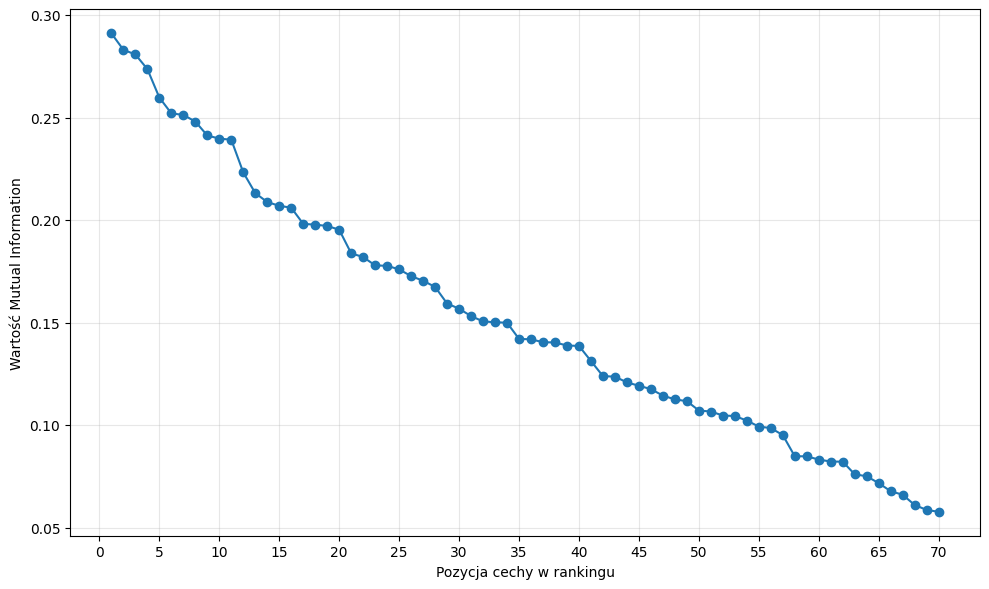

In [24]:
TOP_N = 70
plot_data = mi_df.head(TOP_N).copy()
plot_data["Rank"] = np.arange(1, TOP_N + 1)

plt.figure(figsize=(10, 6))
plt.plot(plot_data["Rank"], plot_data["MI_Score"], marker="o", linewidth=1.5)
plt.xlabel("Pozycja cechy w rankingu")
plt.ylabel("Wartość Mutual Information")
plt.grid(True, alpha=0.3)
plt.xticks(range(0, TOP_N + 1, 5))
plt.tight_layout()
plt.savefig("scree_plot.png", dpi=400, bbox_inches="tight")
plt.show()

#### Wybranie cech do głębszej analizy

In [25]:
selected_features = [
    "BCUT2D_MRHI",
    "MaxPartialCharge",
    "BalabanJ",
    "PEOE_VSA2",
    "MolWt",
    "TPSA",
]

In [26]:
missing = [c for c in selected_features if c not in X_eda.columns]
if missing:
    raise ValueError(f"Brakuje cech w X_eda: {missing}")

plot_df = X_eda[selected_features].copy()
plot_df["activity_bin"] = pd.Series(y).astype(int).values

#### Statystyki opisowe w podziale na klasy aktywności

In [27]:
import pandas as pd

selected_features = [
    "BCUT2D_MRHI",
    "MaxPartialCharge",
    "BalabanJ",
    "PEOE_VSA2",
    "MolWt",
    "TPSA",
]

missing = [c for c in selected_features if c not in X_eda.columns]
if missing:
    raise ValueError(f"Brakuje cech w X_eda: {missing}")

plot_df = X_eda[selected_features].copy()
plot_df["activity_bin"] = pd.Series(y).astype(int).values

def basic_stats(s: pd.Series) -> dict:
    s = s.dropna()
    return {
        "Mean": s.mean(),
        "Med": s.median(),
        "Std": s.std(ddof=1),
    }

rows = []
for feat in selected_features:
    s0 = plot_df.loc[plot_df["activity_bin"] == 0, feat]
    s1 = plot_df.loc[plot_df["activity_bin"] == 1, feat]

    st0 = basic_stats(s0)
    st1 = basic_stats(s1)

    rows.append({
        "Cecha": feat,
        "Nieaktywny_mean": st0["Mean"],
        "Nieaktywny_med": st0["Med"],
        "Nieaktywny_std": st0["Std"],
        "Aktywny_mean": st1["Mean"],
        "Aktywny_med": st1["Med"],
        "Aktywny_std": st1["Std"],
    })

summary_df = pd.DataFrame(rows).round(3)
print("\nStatystyki opisowe (Mean/Med/Std) w podziale na klasy:")
print(summary_df)



Statystyki opisowe (Mean/Med/Std) w podziale na klasy:
              Cecha  Nieaktywny_mean  Nieaktywny_med  Nieaktywny_std  \
0       BCUT2D_MRHI            6.457           6.320           0.760   
1  MaxPartialCharge            0.242           0.254           0.098   
2          BalabanJ            1.543           1.371           0.473   
3         PEOE_VSA2            6.625           4.900           5.322   
4             MolWt          383.415         411.531         151.321   
5              TPSA           53.154          48.000          24.027   

   Aktywny_mean  Aktywny_med  Aktywny_std  
0         6.312        5.985        1.211  
1         0.175        0.134        0.115  
2         2.136        2.171        0.293  
3         1.333        0.000        2.153  
4       247.565      236.702       55.099  
5        36.771       35.250       13.360  


#### Boxploty

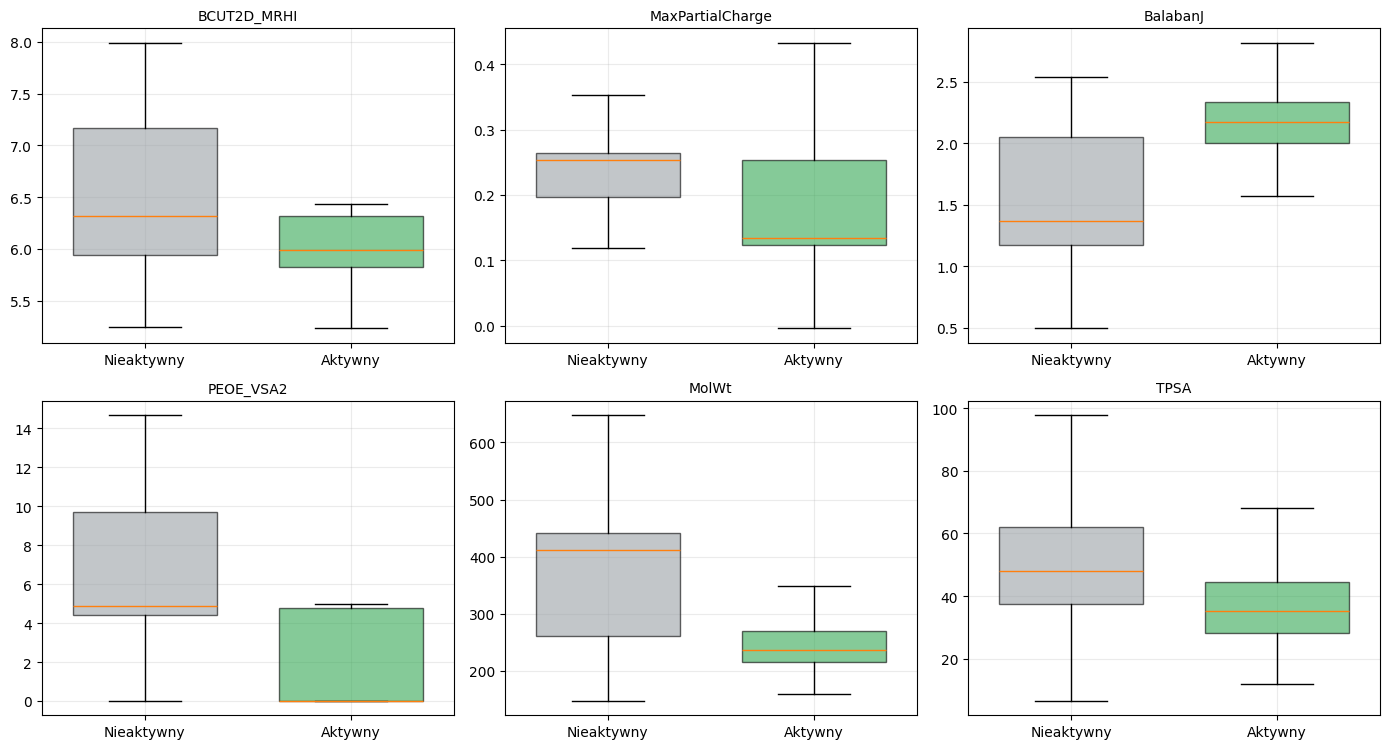

In [28]:
colors = ["#9aa0a6", "#34a853"]  # 0: nieaktywny, 1: aktywny

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()

for i, feat in enumerate(selected_features):
    ax = axes[i]

    data0 = plot_df.loc[plot_df["activity_bin"] == 0, feat].dropna().values
    data1 = plot_df.loc[plot_df["activity_bin"] == 1, feat].dropna().values

    bp = ax.boxplot(
        [data0, data1],
        showfliers=False,
        tick_labels=["Nieaktywny", "Aktywny"],
        patch_artist=True,
        widths=0.7,
    )

    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.6)

    ax.set_title(feat, fontsize=10)
    ax.grid(True, alpha=0.25)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("boxplots_selected_features.png", dpi=400, bbox_inches="tight")

plt.show()

#### test Manna–Whitneya (dla każdej cechy)

In [29]:
test_rows = []
for feat in selected_features:
    g0 = plot_df.loc[plot_df["activity_bin"] == 0, feat].dropna()
    g1 = plot_df.loc[plot_df["activity_bin"] == 1, feat].dropna()

    U, p = mannwhitneyu(g0, g1, alternative="two-sided")

    test_rows.append({
        "Feature": feat,
        "U_stat": float(U),
        "p_value": float(p)
    })

tests_df = pd.DataFrame(test_rows).sort_values("p_value").reset_index(drop=True)
print("\nTest Manna–Whitneya (two-sided):")
print(tests_df.round(6))


Test Manna–Whitneya (two-sided):
            Feature   U_stat  p_value
0          BalabanJ  12177.0      0.0
1         PEOE_VSA2  61111.0      0.0
2             MolWt  62016.0      0.0
3              TPSA  55974.5      0.0
4  MaxPartialCharge  54042.5      0.0
5       BCUT2D_MRHI  47398.5      0.0


## PCA

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eda)

n_features = X_eda.shape[1]
print(f"Liczba cech wejściowych: {n_features}")

Liczba cech wejściowych: 123


In [32]:
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

evr = pca_full.explained_variance_ratio_          # (0–1)
evr_pct = evr * 100                               # (%)
cev = np.cumsum(evr)                              # skumulowana (0–1)

def k_for_threshold(thr: float) -> int:
    return int(np.searchsorted(cev, thr) + 1)

k80 = k_for_threshold(0.80)
k90 = k_for_threshold(0.90)
k95 = k_for_threshold(0.95)

print(f"80% wariancji -> {k80} składowych")
print(f"90% wariancji -> {k90} składowych")
print(f"95% wariancji -> {k95} składowych")

80% wariancji -> 22 składowych
90% wariancji -> 34 składowych
95% wariancji -> 44 składowych


#### Wykres osypiska

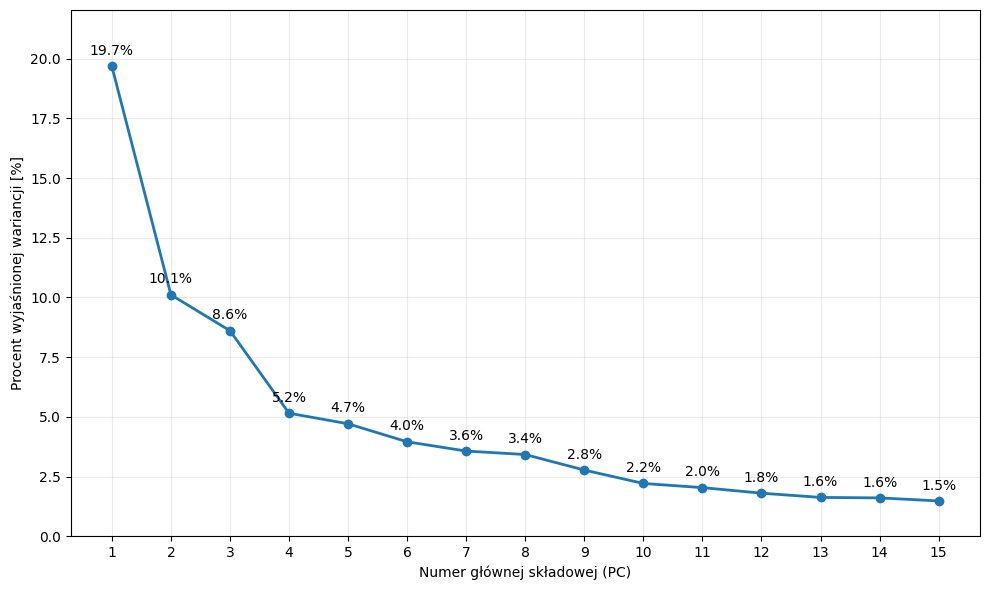

In [33]:
n_show = 15
x = np.arange(1, n_show + 1)
y = evr_pct[:n_show]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, marker="o", linewidth=2)

ymax = y.max()
ax.set_ylim(0, ymax + max(2.0, 0.12 * ymax))

for i, val in enumerate(y, start=1):
    ax.text(i, val + 0.35, f"{val:.1f}%", ha="center", va="bottom", fontsize=10)

ax.set_xlabel("Numer głównej składowej (PC)")
ax.set_ylabel("Procent wyjaśnionej wariancji [%]")
ax.set_xticks(x)
ax.grid(True, alpha=0.25)

fig.tight_layout()
fig.savefig("pca_scree_plot.png", dpi=400, bbox_inches="tight")
plt.show()

#### Top10 ładunków

In [34]:
pca3 = PCA(n_components=3, random_state=42)
pca3.fit(X_scaled)

loadings = pd.DataFrame(
    pca3.components_.T,
    index=X_eda.columns,
    columns=["PC1", "PC2", "PC3"]
)

def top_loadings(load_df: pd.DataFrame, pc: str, top_n: int = 10) -> pd.DataFrame:
    s = load_df[pc]
    out = (
        pd.DataFrame({"Cecha": s.index, "Loading": s.values})
        .assign(abs_loading=lambda d: d["Loading"].abs())
        .sort_values("abs_loading", ascending=False)
        .head(top_n)
        .drop(columns="abs_loading")
        .reset_index(drop=True)
    )
    return out

top_pc1 = top_loadings(loadings, "PC1", 10)
top_pc2 = top_loadings(loadings, "PC2", 10)
top_pc3 = top_loadings(loadings, "PC3", 10)

print("\nTop 10 loadings PC1:\n", top_pc1.to_string(index=False))
print("\nTop 10 loadings PC2:\n", top_pc2.to_string(index=False))
print("\nTop 10 loadings PC3:\n", top_pc3.to_string(index=False))


Top 10 loadings PC1:
                    Cecha   Loading
                   MolWt  0.194512
                BalabanJ -0.181069
                SMR_VSA6  0.170926
        FpDensityMorgan1 -0.160586
                  fr_NH0  0.158781
                SMR_VSA7  0.158007
                     qed -0.157772
                    TPSA  0.157769
             EState_VSA4  0.157302
NumSaturatedHeterocycles  0.155269

Top 10 loadings PC2:
                    Cecha   Loading
        MaxPartialCharge  0.206364
             VSA_EState4 -0.187694
             VSA_EState7 -0.178701
              PEOE_VSA13  0.175363
             VSA_EState5 -0.174328
          MinEStateIndex -0.172377
         fr_alkyl_halide  0.170947
             EState_VSA9 -0.167196
                SMR_VSA4 -0.166311
NumAliphaticHeterocycles  0.163557

Top 10 loadings PC3:
                   Cecha   Loading
            VSA_EState1  0.206564
               SMR_VSA1  0.202449
NumAromaticHeterocycles -0.182893
            EState_VSA8 -

## Analiza skupień

#### Metoda hierarchiczna Warda

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import chi2_contingency, kruskal

In [36]:
y = df["activity_bin"].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eda)

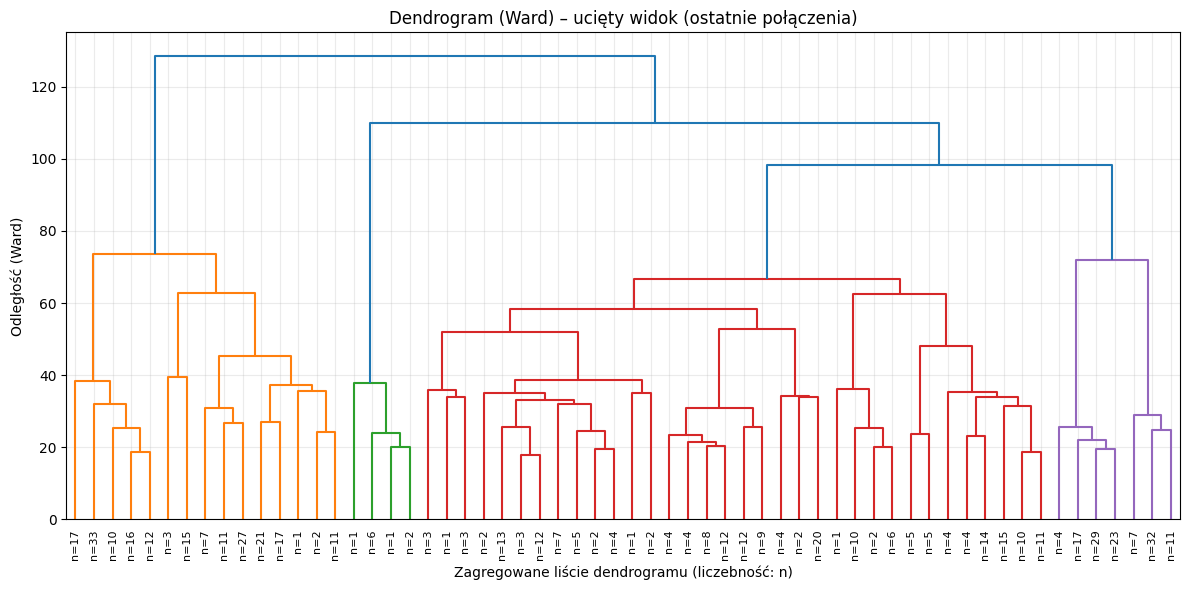

In [37]:
# Linkage Ward (do dendrogramu)
Z_ward = linkage(X_scaled, method="ward")


# Dendrogram ucięty
def plot_dendrogram_counts_only(Z, n_obs, p=60, add_prefix=True, outpath="ward_dendrogram.png"):
    counts = np.zeros(2 * n_obs - 1, dtype=int)
    counts[:n_obs] = 1
    for i in range(n_obs - 1):
        a = int(Z[i, 0])
        b = int(Z[i, 1])
        counts[n_obs + i] = counts[a] + counts[b]

    def leaf_label(node_id):
        n = counts[int(node_id)]
        return f"n={n}" if add_prefix else str(n)

    plt.figure(figsize=(12, 6))
    dendrogram(
        Z,
        truncate_mode="lastp",
        p=p,
        no_labels=False,
        show_leaf_counts=False,
        leaf_label_func=leaf_label,
        leaf_rotation=90,
        leaf_font_size=8
    )
    plt.title("Dendrogram (Ward) – ucięty widok (ostatnie połączenia)")
    plt.xlabel("Zagregowane liście dendrogramu (liczebność: n)")
    plt.ylabel("Odległość (Ward)")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.savefig(outpath, dpi=400, bbox_inches="tight")
    plt.show()

plot_dendrogram_counts_only(Z_ward, n_obs=X_scaled.shape[0], p=60, add_prefix=True)

In [38]:
# Skan metryk jakości dla k=2..12
def scan_ward_metrics(X, k_range=range(2, 13)):
    rows = []
    for k in k_range:
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = model.fit_predict(X)

        sil = silhouette_score(X, labels, metric="euclidean")
        ch  = calinski_harabasz_score(X, labels)
        db  = davies_bouldin_score(X, labels)

        sizes = pd.Series(labels).value_counts()
        rows.append({
            "k": k,
            "silhouette": sil,
            "CH": ch,
            "DB": db,
            "min_cluster_size": int(sizes.min()),
            "max_cluster_size": int(sizes.max())
        })
    return pd.DataFrame(rows)

ward_scores = scan_ward_metrics(X_scaled, range(2, 13))
ward_scores

,k,silhouette,CH,DB,min_cluster_size,max_cluster_size
0,2,0.123487,76.257112,2.332468,203,353
1,3,0.139741,73.195262,1.829540,10,343
2,4,0.126706,71.510439,1.841386,10,220
3,5,0.131536,64.642454,1.886270,10,220
4,6,0.125617,61.119812,1.769040,10,220
5,7,0.144289,58.421336,2.104340,10,133
6,8,0.163457,56.350301,1.992130,10,133
7,9,0.179350,55.302405,1.887460,10,133
8,10,0.194435,54.263440,1.895302,10,97
9,11,0.208293,52.905599,1.819032,10,97


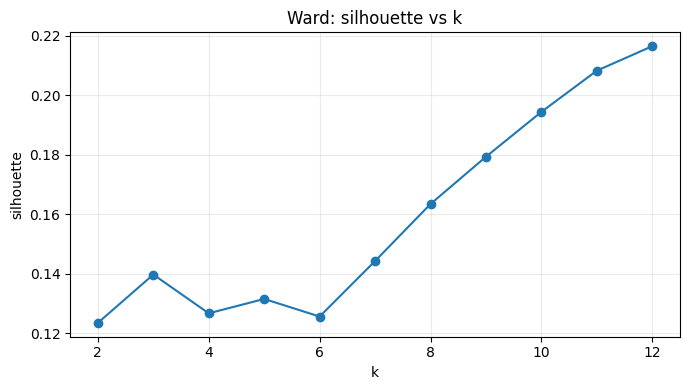

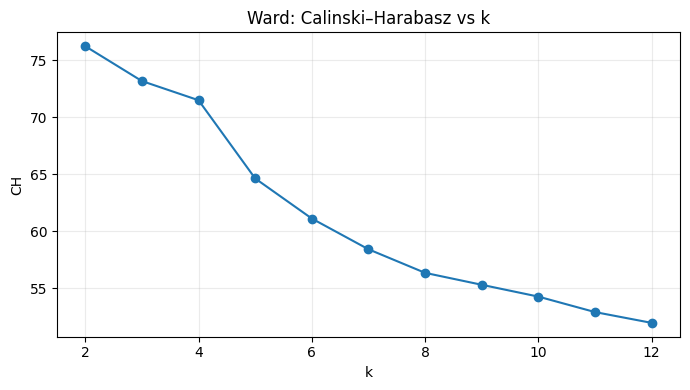

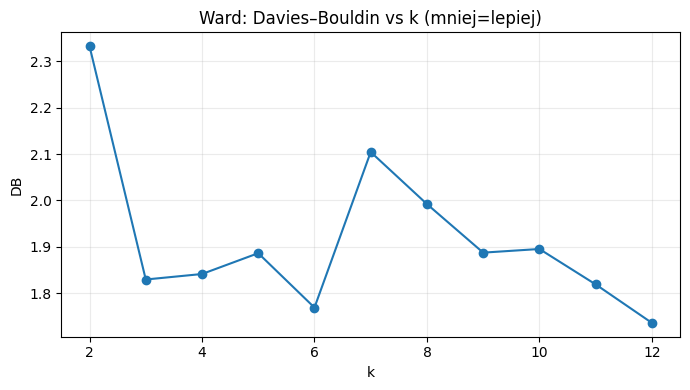

In [39]:
# szybkie wykresy metryk
plt.figure(figsize=(7,4))
plt.plot(ward_scores["k"], ward_scores["silhouette"], marker="o")
plt.title("Ward: silhouette vs k")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(ward_scores["k"], ward_scores["CH"], marker="o")
plt.title("Ward: Calinski–Harabasz vs k")
plt.xlabel("k"); plt.ylabel("CH")
plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(ward_scores["k"], ward_scores["DB"], marker="o")
plt.title("Ward: Davies–Bouldin vs k (mniej=lepiej)")
plt.xlabel("k"); plt.ylabel("DB")
plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

In [40]:
#  Wybór k + etykiety klastrów
K = 4 
ward_model = AgglomerativeClustering(n_clusters=K, linkage="ward")
labels_ward = ward_model.fit_predict(X_scaled)

print("Rozkład liczności klastrów:\n", pd.Series(labels_ward).value_counts().sort_index())

Rozkład liczności klastrów:
 0    203
1    123
2     10
3    220
Name: count, dtype: int64


In [41]:
# Kontyngencja cluster × activity_bin
dfc = df.copy()
dfc["cluster"] = labels_ward
dfc["activity_bin"] = dfc["activity_bin"].astype(int)

cont_counts = pd.crosstab(dfc["cluster"], dfc["activity_bin"])
cont_props  = pd.crosstab(dfc["cluster"], dfc["activity_bin"], normalize="index")

chi2, p, dof, expected = chi2_contingency(cont_counts)
n = cont_counts.to_numpy().sum()
r, c = cont_counts.shape
V = np.sqrt(chi2 / (n * min(r-1, c-1)))

print("Tabela liczności:\n", cont_counts)
print("\nUdziały w klastrach:\n", cont_props.round(3))
print(f"\nChi2={chi2:.3f}, p={p:.4g}, Cramér's V={V:.3f}")
print(f"Minimalna oczekiwana liczność: {expected.min():.2f}")

Tabela liczności:
 activity_bin    0    1
cluster               
0              57  146
1              64   59
2              10    0
3             184   36

Udziały w klastrach:
 activity_bin      0      1
cluster                   
0             0.281  0.719
1             0.520  0.480
2             1.000  0.000
3             0.836  0.164

Chi2=141.443, p=1.846e-30, Cramér's V=0.504
Minimalna oczekiwana liczność: 4.33


In [42]:
# Statystyki opisowe dla interpretowalnych cech
cechy = [
    "MolWt", "MolLogP", "TPSA", "HeavyAtomCount",
    "NumHDonors", "NumHAcceptors", "NumRotatableBonds",
    "RingCount", "NumAromaticRings", "FractionCSP3", "MolMR"
]

def iqr(x):
    x = np.asarray(x)
    return np.percentile(x, 75) - np.percentile(x, 25)

desc = dfc.groupby("cluster")[cechy].agg(["median", iqr, "mean", "std"])
desc

MolWt                                   MolLogP            \
           median       iqr        mean         std  median       iqr   
cluster                                                                 
0        229.6820   60.7525  235.863847   56.347023  2.5413  1.007690   
1        250.7290   39.9430  257.952293   50.326852  1.5042  1.081360   
2        952.6415  129.2350  999.306200  125.399745  8.5202  0.597975   
3        426.4920   54.5765  412.897573   65.315627  3.7423  1.336275   

                                TPSA           ... NumAromaticRings            \
             mean       std   median      iqr  ...             mean       std   
cluster                                        ...                              
0        2.619954  0.731049   35.250  18.4600  ...         1.527094  0.662283   
1        1.632084  0.783860   32.340   9.2300  ...         1.065041  0.278751   
2        8.261360  0.515167  125.635  29.6625  ...         4.800000  0.421637   
3        3.559692  1.126417   54.260  22.7700  ...         2.681818  0.739392   

        FractionCSP3                                    MolMR            \
              median       iqr      mean       std     median       iqr   
cluster                                                                   
0           0.428571  0.133333  0.406706  0.097627   62.08840  14.20065   
1           0.461538  0.083333  0.466214  0.065385   63.32690   5.94050   
2           0.518875  0.060983  0.534090  0.046798  257.09175  34.22560   
3           0.434783  0.111111  0.441295  0.092996  119.40480  17.08345   

                                
               mean        std  
cluster                         
0         65.677614  14.963588  
1         66.975829  11.532821  
2        269.035110  31.240951  
3        115.055228  17.264443  

[4 rows x 44 columns]

In [43]:
features_for_table = ["MolWt", "MolLogP", "TPSA", "NumAromaticRings", "MolMR"]

def iqr(x):
    x = np.asarray(x, dtype=float)
    return np.percentile(x, 75) - np.percentile(x, 25)

# Statystyki opisowe: median, IQR, mean, std
desc = dfc.groupby("cluster")[features_for_table].agg(["median", iqr, "mean", "std"])

# Funkcja formatująca jedną komórkę tabeli
def fmt_cell(med, iqr_val, mean, std, decimals=2):
    return f"{med:.{decimals}f} ({iqr_val:.{decimals}f}); {mean:.{decimals}f} ± {std:.{decimals}f}"

out = pd.DataFrame(index=desc.index)

for feat in features_for_table:
    med = desc[(feat, "median")]
    iq = desc[(feat, "iqr")]
    mu = desc[(feat, "mean")]
    sd = desc[(feat, "std")]
    out[feat] = [fmt_cell(m, q, a, s, decimals=2) for m, q, a, s in zip(med, iq, mu, sd)]


Mapowanie klaster -> kolor dendrogramu: {np.int64(0): 'C1', np.int64(1): 'C4', np.int64(2): 'C2', np.int64(3): 'C3'}


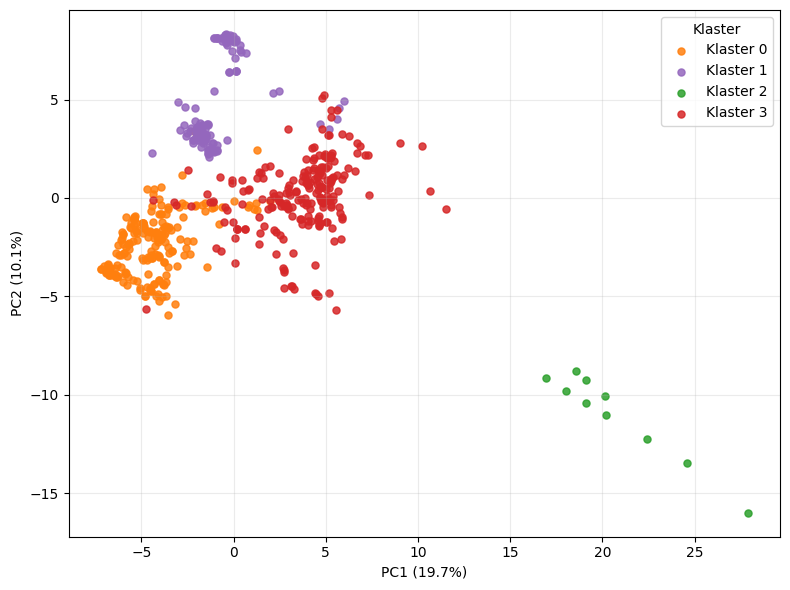

In [44]:
# PCA2D: kolory jak na dendrogramie (spójne z k=K)
# Próg odpowiadający cięciu na k klastrów
t = Z_ward[-(K-1), 2] - 1e-6

# odczyt kolorów liści
d = dendrogram(Z_ward, color_threshold=t, no_plot=True)
leaves = np.array(d["leaves"])
leaf_colors = np.array(d["leaves_color_list"])

# Kolor przypisany do każdej obserwacji
n_obs = X_scaled.shape[0]
color_by_obs = np.empty(n_obs, dtype=object)
color_by_obs[leaves] = leaf_colors

# Mapowanie: klaster -> dominujący kolor z dendrogramu
cluster_to_color = {}
for cl in np.unique(labels_ward):
    cols = color_by_obs[labels_ward == cl]
    cluster_to_color[cl] = Counter(cols).most_common(1)[0][0]

print("Mapowanie klaster -> kolor dendrogramu:", cluster_to_color)

# PCA i wykres
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)
ev = pca2.explained_variance_ratio_.sum()

plt.figure(figsize=(8, 6))
for cl in np.unique(labels_ward):
    mask = labels_ward == cl
    plt.scatter(
        X_pca2[mask, 0], X_pca2[mask, 1],
        s=26, alpha=0.85,
        color=cluster_to_color[cl],
        label=f"Klaster {cl}"
    )

plt.xlabel("PC1 (19.7%)")
plt.ylabel("PC2 (10.1%)")
plt.grid(alpha=0.25)
plt.legend(title="Klaster", loc="best")
plt.tight_layout()
plt.savefig("pca_ward.png", dpi=400, bbox_inches="tight")
plt.show()

#### K-średnich

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import chi2_contingency

In [46]:
y = df["activity_bin"].astype(int).values  # tylko post-hoc

In [47]:
#  Skan metryk jakości dla k = 2..12
def scan_kmeans_metrics(X, k_range=range(2, 13), seed=42, n_init=20):
    rows = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=seed, n_init=n_init)
        labels = model.fit_predict(X)

        sil = silhouette_score(X, labels)
        ch  = calinski_harabasz_score(X, labels)
        db  = davies_bouldin_score(X, labels)

        sizes = pd.Series(labels).value_counts()
        rows.append({
            "k": k,
            "silhouette": sil,
            "CH": ch,
            "DB": db,
            "min_cluster_size": int(sizes.min()),
            "max_cluster_size": int(sizes.max())
        })
    return pd.DataFrame(rows)

kmeans_scores = scan_kmeans_metrics(X_scaled, range(2, 13))
print(kmeans_scores)

     k  silhouette         CH        DB  min_cluster_size  max_cluster_size
0    2    0.174225  87.113963  2.354704               207               349
1    3    0.141746  76.107683  1.767531                10               346
2    4    0.129442  74.671971  1.813423                10               223
3    5    0.141990  66.866484  1.836654                10               210
4    6    0.152269  63.818506  1.880563                10               169
5    7    0.159974  61.663436  1.705985                10               176
6    8    0.179182  59.834876  1.883870                10               117
7    9    0.196438  57.099536  1.835850                10               117
8   10    0.208512  55.997862  1.797251                10               105
9   11    0.205687  54.181678  1.816662                10                85
10  12    0.207696  51.289974  1.790149                10                90


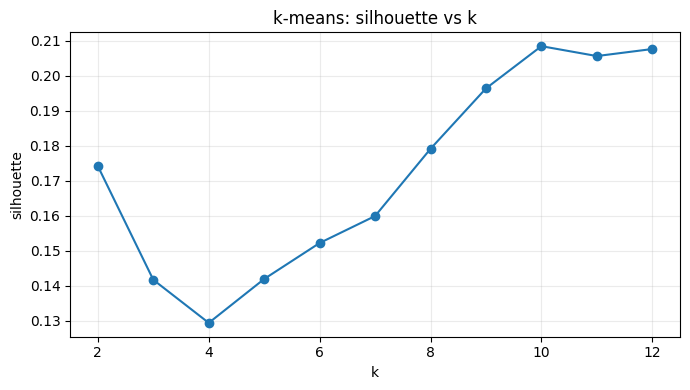

In [48]:
# wykres silhouette
plt.figure(figsize=(7,4))
plt.plot(kmeans_scores["k"], kmeans_scores["silhouette"], marker="o")
plt.title("k-means: silhouette vs k")
plt.xlabel("k"); plt.ylabel("silhouette")
plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

In [49]:
#  Wybór k (dla porównania z Wardem trzymamy k=4)
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=50)
labels_km = kmeans.fit_predict(X_scaled)

print("Rozkład liczności klastrów (k-means):\n",
      pd.Series(labels_km).value_counts().sort_index())

Rozkład liczności klastrów (k-means):
 0    198
1     10
2    125
3    223
Name: count, dtype: int64


In [50]:
# Kontyngencja cluster × activity_bin
dfc_km = df.copy()
dfc_km["cluster_km"] = labels_km
dfc_km["activity_bin"] = dfc_km["activity_bin"].astype(int)

cont_counts = pd.crosstab(dfc_km["cluster_km"], dfc_km["activity_bin"])
cont_props  = pd.crosstab(dfc_km["cluster_km"], dfc_km["activity_bin"], normalize="index")

chi2, p, dof, expected = chi2_contingency(cont_counts)
n = cont_counts.to_numpy().sum()
r, c = cont_counts.shape
V = np.sqrt(chi2 / (n * min(r-1, c-1)))

print("\nTabela liczności:\n", cont_counts)
print("\nUdziały w klastrach:\n", cont_props.round(3))
print(f"\nChi2={chi2:.3f}, p={p:.4g}, Cramér's V={V:.3f}")
print(f"Minimalna oczekiwana liczność: {expected.min():.2f}")


Tabela liczności:
 activity_bin    0    1
cluster_km            
0              50  148
1              10    0
2              60   65
3             195   28

Udziały w klastrach:
 activity_bin      0      1
cluster_km                
0             0.253  0.747
1             1.000  0.000
2             0.480  0.520
3             0.874  0.126

Chi2=177.055, p=3.814e-38, Cramér's V=0.564
Minimalna oczekiwana liczność: 4.33


In [51]:
# tabelka n + active_rate
cluster_overview = pd.DataFrame({
    "n": dfc_km["cluster_km"].value_counts().sort_index(),
    "inactive(0)": cont_counts.get(0, pd.Series(dtype=int)),
    "active(1)": cont_counts.get(1, pd.Series(dtype=int)),
    "active_rate": cont_props.get(1, pd.Series(dtype=float))
}).sort_index()

print("\nPodsumowanie klastrów:\n", cluster_overview)


Podsumowanie klastrów:
               n  inactive(0)  active(1)  active_rate
cluster_km                                          
0           198           50        148     0.747475
1            10           10          0     0.000000
2           125           60         65     0.520000
3           223          195         28     0.125561


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21920\3297137279.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(clusters))


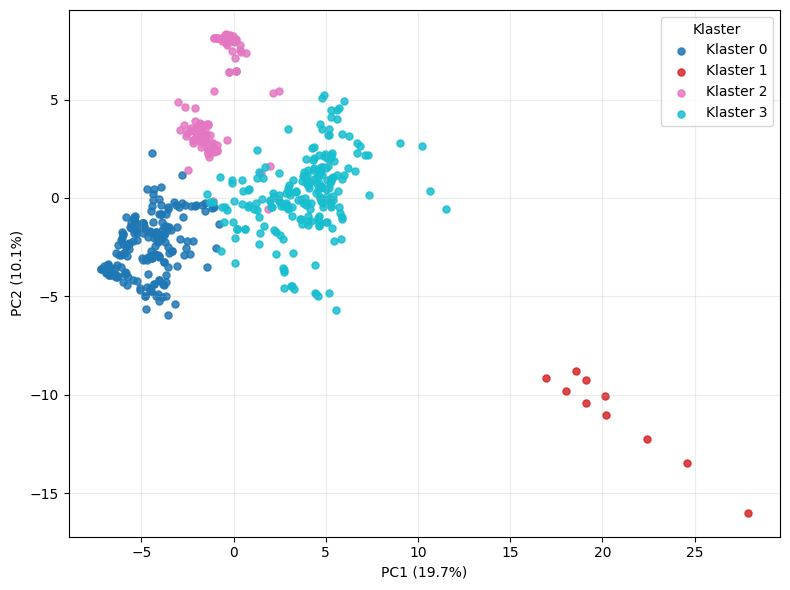

In [52]:
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)
ev = pca2.explained_variance_ratio_.sum()

clusters = np.unique(labels_km)
cmap = plt.cm.get_cmap("tab10", len(clusters))

plt.figure(figsize=(8, 6))
for i, c in enumerate(clusters):
    m = labels_km == c
    plt.scatter(X_pca2[m, 0], X_pca2[m, 1],
                s=26, alpha=0.85, color=cmap(i), label=f"Klaster {c}")

plt.xlabel("PC1 (19.7%)"); plt.ylabel("PC2 (10.1%)")
plt.grid(alpha=0.25)
plt.legend(title="Klaster", loc="best")
plt.tight_layout()
plt.savefig("pca_kmeans.png", dpi=400, bbox_inches="tight")
plt.show()